In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

<h2>Data</h2>

In [11]:
# read data into dataframe
df = pd.read_csv('../../../Data/Bitcoindata.csv',parse_dates=True,index_col='Date')


In [12]:
#Change the name of the column
df.columns=['Close Price']
# sort the data ascending in datetime
df.sort_index(ascending=True,inplace=True)

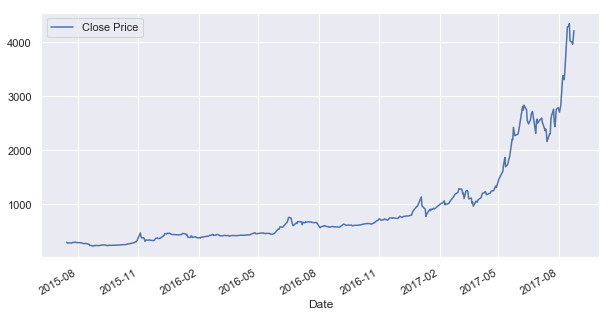

In [13]:
df.plot(figsize=(10,5));

Calculate the log returns

In [14]:
df['Ret']= df['Close Price'].pct_change(periods=1)
df.head()

,Close Price,Ret
Date,,
2015-07-15,291.2523,NaN
2015-07-16,276.1400,-0.051887
2015-07-17,278.2650,0.007695
2015-07-21,278.9625,0.002507
2015-07-22,277.0599,-0.006820


In [15]:
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.dropna(inplace=True)

Calculate the Volatility

In [16]:
print('Volatility of Bitcoin =',np.round(df['LogRet'].std()*np.sqrt(250)*100,2), '%')

Volatility of Bitcoin = 73.87 %


<h2> Are Bitcoin prices Normally distributed ?<h2>

In [17]:
from scipy import stats

Calculate quantiles for a probability plot, and optionally show the plot.
Generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default).<br>
Probplot optionally calculates a best-fit line for the data and plots the results using Matplotlib or a given plot function.

R Squared: 91.55584320796942  %


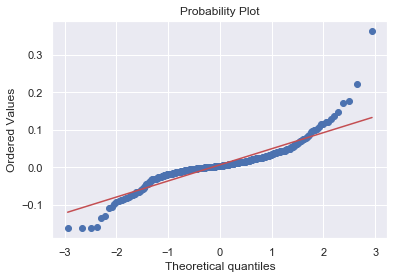

In [18]:
data = np.array(df['LogRet'])
res = stats.probplot(data,fit=True,plot=plt,dist='norm')
print('R Squared:',100*res[-1][-1],' %')

A better candidate to replace the normal distribution function is the laplace-function:

R Squared: 96.70803988238006  %


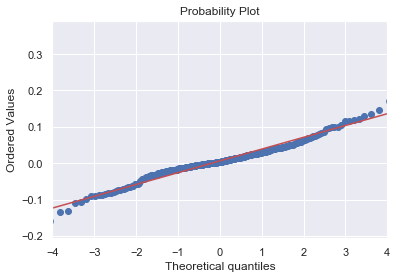

In [19]:
data = np.array(df['LogRet'])
res = stats.probplot(data,fit=True,plot=plt,dist='laplace')
plt.xlim([-4,4])
print('R Squared:',100*res[-1][-1],' %')

The <b>Kolmogorov-Smirnov</b> test. <br>
Using the cumulative density function (<b>CDF</b>) of the returns and compare those with a fitted CDF using the kolmogorov-smirnov two sample test (scipy.stats.kstest). <br>
This test will allow us to verify of the CDF of the two series come from the same distribution ( in our case the Normal distribution function) <br>
The kstest outputs:
<ol>
<li>the ks statistic
<li> a p-value
</ol></br>
<br>
P-values less than 0.05 means we can reject the null hypothesis that the two series were drawn from the same distribution. The smaller the p-value the more confident we are that they came from a different distributions.

First we will analyze the entire return series, then compare the test across years.

Documentation : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
 

In [20]:
print('Testing normal distribution:',stats.kstest(data, 'norm'))
print('->Reject Null hypothesis')

Testing normal distribution: KstestResult(statistic=0.4422787810822094, pvalue=6.831837019807413e-76)
->Reject Null hypothesis


<h2>Kernel Density Function </h2> <br>
A Non-Parametric Density Estimate (= Kernel)

In [21]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

Calculate the Kernel Density Fit

In [22]:
data = np.array(df['LogRet']).reshape(-1,1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.02)
kde.fit(data);

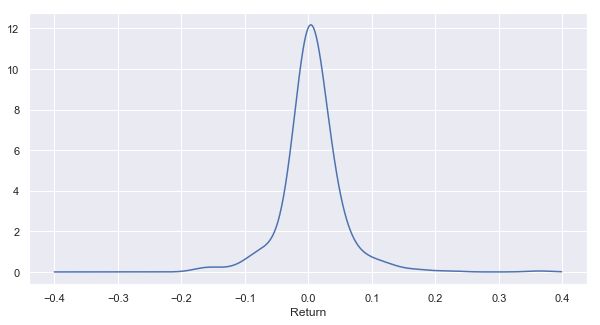

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(-0.4,0.4,0.001).reshape(-1,1),
        np.exp(kde.score_samples(np.arange(-0.4,0.4,0.001).reshape(-1,1))))
ax.set_xlabel('Return');

Parametric Density Estimation <br>
Which is the optimal bandwidth and optimal kernel (tophat or gaussian)

In [24]:
data = np.array(df['LogRet']).reshape(-1,1)
param_grid = {'bandwidth': np.arange(0.001,0.05,0.001),
              'kernel':['gaussian','tophat']}
grid = GridSearchCV(KernelDensity(),param_grid)
grid.fit(data)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049]), 'kernel': ['gaussian', 'tophat']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
print(grid.best_params_['kernel'])
print(grid.best_params_['bandwidth'])

gaussian
0.022000000000000002


Plotting the density function

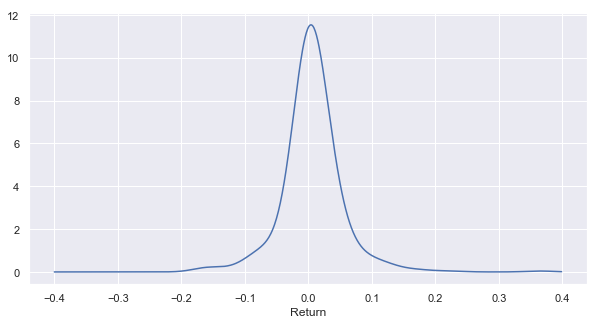

In [26]:
kde_opt = KernelDensity(kernel=grid.best_params_['kernel'], bandwidth=grid.best_params_['bandwidth'])
kde_opt.fit(data);
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(-0.4,0.4,0.001).reshape(-1,1),
        np.exp(kde_opt.score_samples(np.arange(-0.4,0.4,0.001).reshape(-1,1))))
ax.set_xlabel('Return');

<h2>Gaussian Mixture</h2> <br>
Studying the bitcoin returns as the combination of <b>three</b> gaussians. Each gaussian represents a regime

In [27]:
from sklearn import mixture

In [28]:
clf = mixture.GaussianMixture(n_components=3)
clf.fit(data.reshape(-1,1))


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [29]:
for i in np.arange(0,3):
    print('Regime',i)
    print('Prob',clf.weights_[i]*100,'%')
    print('Avg:',clf.means_[i]*100,'%')
    print('\n')

Regime 0
Prob 78.46639000083843 %
Avg: [0.58842376] %


Regime 1
Prob 8.694814418688104 %
Avg: [-7.402553] %


Regime 2
Prob 12.83879558047343 %
Avg: [6.33833785] %




In [30]:
for i in np.arange(0,len(clf.weights_)):
    print('Regime',i,np.round(100*clf.weights_[i],2),'%',
          '[Mean=',np.round(100*clf.means_[i,0],2),
          '%, StDev=',np.round(100*np.sqrt(clf.covariances_[i][0,0]),2),']')

Regime 0 78.47 % [Mean= 0.59 %, StDev= 1.92 ]
Regime 1 8.69 % [Mean= -7.4 %, StDev= 4.47 ]
Regime 2 12.84 % [Mean= 6.34 %, StDev= 7.58 ]


How does one know which regime we are in ?

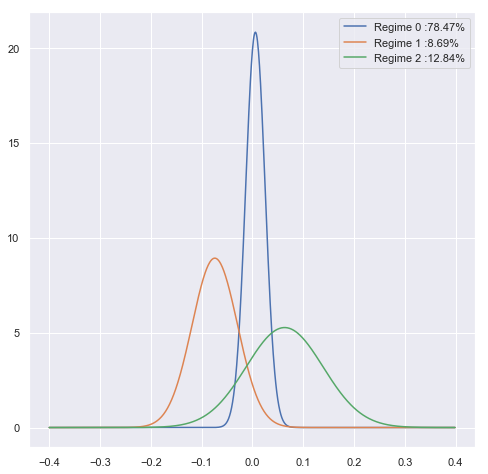

In [31]:
fig = plt.subplots(1,1,figsize=(8,8))
x = np.arange(-0.4,0.4,0.001)
for i in np.arange(0,len(clf.weights_)):
    plt.plot(x,
             stats.norm.pdf(x,loc=clf.means_[i,0],scale=np.sqrt(clf.covariances_[i][0,0])),
             label='Regime '+str(i)+' :'+str(np.round(100*clf.weights_[i],2))+'%')
    plt.legend()